# Выявление закономерностей, определяющих успешность игры.

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.
В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

## Изучение данных.

In [1]:
# подгружаем библиотеки
import pandas as pd
import math
import numpy as np 
import scipy.stats as sp
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
import datetime as dt

In [2]:
# открываем файл
games = pd.read_csv('/datasets/games.csv')
display(games.head(5)) 
games.info()
print(games['Critic_Score'].unique())
print(games['User_Score'].unique())
print(games['Rating'].unique())

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
[76. nan 82. 80. 89. 58. 87. 91. 61. 97. 95. 77. 88. 83. 94. 93. 85. 86.
 98. 96. 90. 84. 73. 74. 78. 92. 71. 72. 68. 62. 49. 67. 81. 66. 56. 79.
 70. 59. 64. 75. 60. 63. 69. 50. 25. 42. 44. 55. 48. 57. 29. 47. 65. 54.
 20. 53. 37. 38. 33. 52. 30. 32. 43. 45. 51. 40. 46. 39. 34. 35. 41. 36.
 28. 31. 27. 26. 19. 23. 24. 21. 17. 22. 13.]
['8' nan '8.3' '8.5' '6.6' '8.4' '8.6' '7.7' '

### Вывод
Мы ознакомились с данными. Обнаружили следующее:
- названия столбцов начинаются с верхнего регистра, переведем в нижний;
- в столбце Name есть пропуски, оставим как есть;
- в столбце Platform все отлично;
- в столбце Year_of_Release пропуски оставим как есть, а тип данных поменяем на int64;
- в столбце Genre есть пропуски, оставим как есть;
- в столбцах NA_sales, EU_sales, JP_sales и Other_sales пропусков нет, тип данных оставим как есть, чтоб ничего не потерять при подсчетах;
- в столбце Critic_Score много пропусков, возможно это связано с тем, что игры не очень популярны и на них нет оценки критиков. Заполнить их не получится, но мы поменяем тип данных на int64;
- в столбце User_Score есть пропуски, а также 'tbd', что примерно означает "будет заполен позже", попробуем заменить их на Nan, также поменяем тип данных на int64;
- в столбце Rating всё оставим без изменения.

## Предобработка данных

In [3]:
# переведем название столбцов к нижнему регистру
games.columns = games.columns.str.lower()

# заменим в столбце user_score tbd на Nan
games['user_score'] = games['user_score'].replace('tbd', np.NaN)
games['user_score'] = games['user_score'].astype("float")

# поменяем тип данных в столбцах year_of_release, critic_score, user_score
games[['year_of_release', 'critic_score']] = games[
    ['year_of_release', 'critic_score']].round().astype('Int64')
  
games.info()
display(games.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16446 non-null Int64
genre              16713 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       8137 non-null Int64
user_score         7590 non-null float64
rating             9949 non-null object
dtypes: Int64(2), float64(5), object(4)
memory usage: 1.4+ MB


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
# посчитаем суммарные продажи во всех регионах

games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']
display(games.head(5))

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


### Вывод
Мы провели следующие преобразования:
- перевели название столбцов в нижний регистр с помощью str.lower();
- замениили в столбце user_score tbd на Nan с помощью replace();
- поменяли тип данных в столбцах year_of_release, critic_score, user_score с помощью round().astype('Int64');
- посчитали суммарные продажи во всех регионах и добавили их в столбец total_sales.

Теперь данные готовы для анализа.


## Исследовательский анализ данных


### Посчитаем сколько игр выпускалось в разные годы

2008    1427
2009    1426
2010    1255
2007    1197
2011    1136
2006    1006
2005     939
2002     829
2003     775
2004     762
2012     653
2015     606
2014     581
2013     544
2016     502
2001     482
1998     379
2000     350
1999     338
1997     289
1996     263
1995     219
1994     121
1993      62
1981      46
1992      43
1991      41
1982      36
1986      21
1983      17
1989      17
1987      16
1990      16
1988      15
1984      14
1985      14
1980       9
Name: year_of_release, dtype: int64


Text(0, 0.5, 'количество')

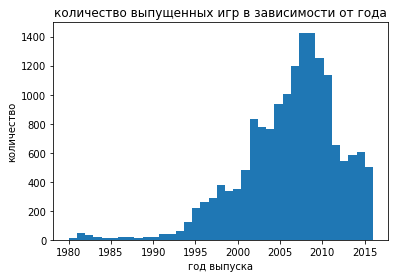

In [5]:
# посчитаем сколько игр выпускалось в разные годы
print(games.year_of_release.value_counts())
# посмотрим гистограмму
plt.hist(games.year_of_release,bins=37)
plt.title('количество выпущенных игр в зависимости от года')
plt.xlabel('год выпуска')
plt.ylabel('количество')

### Вывод
Наибольшее количество игры было выпущено в период с 2005 по 2011 года. А годы до 1994 го можем вообще опустить, в тот период было слишком мало игр. Это связано с тем, что еще не было большинства платформ.

### Посмотрим как менялись продажи на платформах

In [6]:
print(games.groupby('platform')['total_sales'].sum(
     ).sort_values(ascending=False))

platform
PS2     1255.77
X360     971.42
PS3      939.65
Wii      907.51
DS       806.12
PS       730.86
GBA      317.85
PS4      314.14
PSP      294.05
PC       259.52
3DS      259.00
XB       257.74
GB       255.46
NES      251.05
N64      218.68
SNES     200.04
GC       198.93
XOne     159.32
2600      96.98
WiiU      82.19
PSV       54.07
SAT       33.59
GEN       30.77
DC        15.95
SCD        1.86
NG         1.44
WS         1.42
TG16       0.16
3DO        0.10
GG         0.04
PCFX       0.03
Name: total_sales, dtype: float64


In [7]:
# самые популярные платформы: PS2, X360, PS3, Wii, DS, PS. Соберем их в одну таблицу
platform_list=['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS'] 
top_platforms = games[games.platform.isin(platform_list)]
display(top_platforms)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89,8.5,E,29.80
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58,6.6,E,28.91
...,...,...,...,...,...,...,...,...,...,...,...,...
16700,Mezase!! Tsuri Master DS,DS,2009,Sports,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16704,Plushees,DS,2008,Simulation,0.01,0.00,0.00,0.00,NaN,NaN,E,0.01
16709,SCORE International Baja 1000: The Official Game,PS2,2008,Racing,0.00,0.00,0.00,0.00,NaN,NaN,NaN,0.00
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01


PS2
X360
PS3
Wii
DS
PS


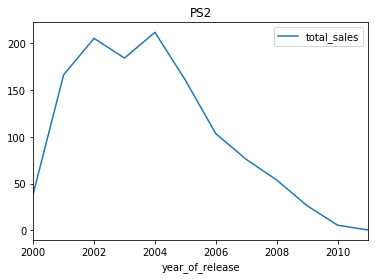

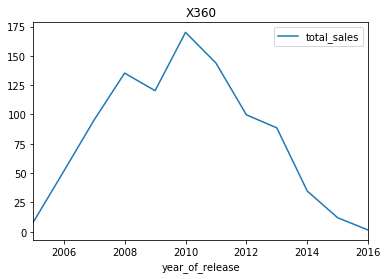

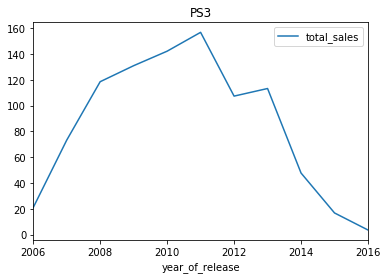

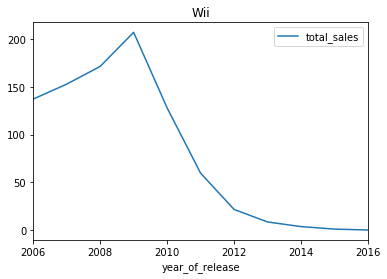

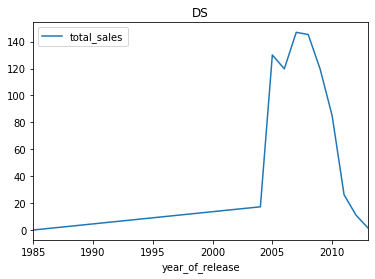

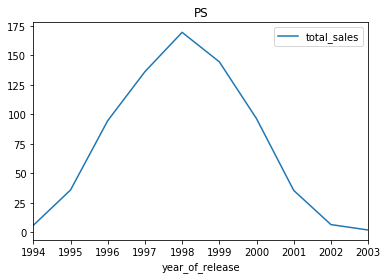

In [8]:
# сделаем сводную таблицу на основе избранных платформ

platform_sales = (
    top_platforms
    .pivot_table(index='platform', values='total_sales', aggfunc='sum')
    .sort_values('total_sales', ascending=False)
)

# затем в цикле построим графики

for platform in platform_sales.index:
    print(platform)
    
    top_platforms.query('platform == @platform').pivot_table(
        index='year_of_release', values='total_sales', aggfunc='sum').plot()
    plt.title(platform)

In [9]:
# посчитаем среднюю продолжительность
platform_years_pivot = games.pivot_table(index = 'platform', values = 'year_of_release', aggfunc = ['min', 'max'])

platform_years_pivot['platform_years'] = platform_years_pivot[(
    'max', 'year_of_release')] - platform_years_pivot[('min', 'year_of_release')]
display(platform_years_pivot.sort_values(by = 'platform_years', ascending = False).head(10))
platform_years = platform_years_pivot['platform_years'].median()
print(f'Среднее время существования платформы: {platform_years:.1f} лет')

,min,max,platform_years
,year_of_release,year_of_release,
platform,,,
PC,1985,2016,31
DS,1985,2013,28
GB,1988,2001,13
X360,2005,2016,11
PSP,2004,2015,11
PS2,2000,2011,11
NES,1983,1994,11
DC,1998,2008,10


Среднее время существования платформы: 6.0 лет


### Вывод
Судя по графикам топ-6 платформ мы видим что популярность платформы в среднем растет 3-5 лет, затем примерно столько же времени требуется до полного забвения. Также посчитал среднее время существования всех платформ (вернее медиану, чтобю избезать выбрасов, так как к примеру PC и DS точно будет мешать). В среднем назвал бы сроком жизни платформы 6-7 лет.

### Создадим таблицу с данными только за актуальный период.
Учитывая графики, которые мы увидели, за актуальный период возьмем данные за последние 5 лет, начиная с 2012 года.

In [10]:
actual_games = games[games.year_of_release >= 2012]
display(actual_games.head(5))

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,NaN,14.60
34,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83,5.3,M,13.79


### Какие платформы лидируют по продажам.

In [11]:
print(actual_games.groupby('platform')['total_sales'].sum(
     ).sort_values(ascending=False))

platform
PS4     314.14
PS3     288.79
X360    236.54
3DS     194.61
XOne    159.32
WiiU     82.19
PC       62.65
PSV      49.18
Wii      35.37
DS       12.55
PSP      11.19
Name: total_sales, dtype: float64


platform,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,,,
2012,51.36,11.01,23.22,107.36,NaN,7.69,16.19,21.71,17.56,99.74,NaN
2013,56.57,1.54,12.38,113.25,25.99,3.14,10.59,8.59,21.65,88.58,18.96
2014,43.76,NaN,13.28,47.76,100.00,0.24,11.90,3.75,22.03,34.74,54.07
2015,27.78,NaN,8.52,16.82,118.90,0.12,6.25,1.14,16.35,11.96,60.14
2016,15.14,NaN,5.25,3.60,69.25,NaN,4.25,0.18,4.60,1.52,26.15


Text(0, 0.5, 'продажи')

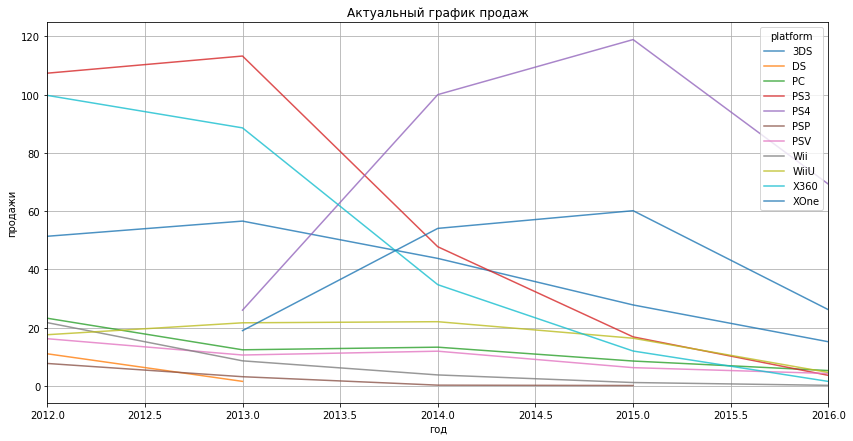

In [12]:
actual_pivot = actual_games.pivot_table(columns='platform', index='year_of_release', values='total_sales', aggfunc='sum')
display(actual_pivot.head(5))                                                                  
plot = actual_pivot.plot(figsize=(14,7), legend=True, grid=True, alpha=0.8, 
                  title='Актуальный график продаж')
plt.xlabel('год')
plt.ylabel('продажи')

### Вывод
Лидеры по продажам за последние годы: PS4, XOne и 3DS. Так как данные за 2016 год еще не полностью выгружены мы видим, что продажи по платформам PS4 и XOne находятся в росте, а продажи 3DS постепенно падают, по графику заметно, что платформа теряет популярность. Значит оратим особое внимание на PS4 и XOne.

###  Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам.


PS4
count    392.000000
mean       0.801378
std        1.609456
min        0.010000
25%        0.060000
50%        0.200000
75%        0.730000
max       14.630000
Name: total_sales, dtype: float64
XOne
count    247.000000
mean       0.645020
std        1.036139
min        0.010000
25%        0.060000
50%        0.220000
75%        0.685000
max        7.390000
Name: total_sales, dtype: float64
3DS
count    396.000000
mean       0.491439
std        1.387161
min        0.010000
25%        0.040000
50%        0.110000
75%        0.312500
max       14.600000
Name: total_sales, dtype: float64


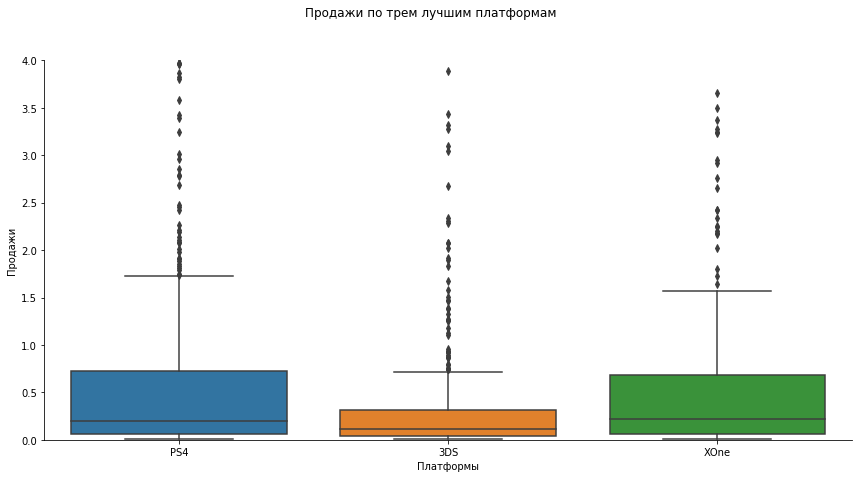

In [13]:
actual_games2 = actual_games[(actual_games['platform'] == 'PS4') | 
                             (actual_games['platform'] == 'XOne') | 
                             (actual_games['platform'] == '3DS')].reset_index()

plot = sns.catplot(
    data = actual_games2, x='platform', y='total_sales', kind='box', height=6, 
                    aspect=2, legend_out=False)
plot.set(ylim=(0, 4))
plot.set_axis_labels(x_var='Платформы', y_var='Продажи')

plot.fig.suptitle('Продажи по трем лучшим платформам', y=1.1)
print()
print('PS4')
print(actual_games2[actual_games2['platform'] == 'PS4']['total_sales'].describe())
print('XOne')
print(actual_games2[actual_games2['platform'] == 'XOne']['total_sales'].describe())
print('3DS')
print(actual_games2[actual_games2['platform'] == '3DS']['total_sales'].describe())

### Вывод
Внимательно изучив 3 лучшие платформы за актуальный период мы видим, что лучше всех дела обстоят у PS4.
Средний показатель 0.8 против 0.64 и 0.49, третий квартиль 0.73 против 0.68 и 0.31 миллиона $. Второе место уверенно занимает XOne, ну а дела у 3DS обстоят гораздо хуже, похоже лучшие ее годы уже позади.

### Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков.

1. PS4

In [14]:
# создадим таблицу для PS4 со столбцами только из отзывов и выручки
actual_games2_ps4 = actual_games2[(
    actual_games2['platform'] == 'PS4')][['total_sales', 'critic_score', 'user_score']]
display(actual_games2_ps4.corr())

,total_sales,critic_score,user_score
total_sales,1.000000,0.406568,-0.031957
critic_score,0.406568,1.000000,0.557654
user_score,-0.031957,0.557654,1.000000


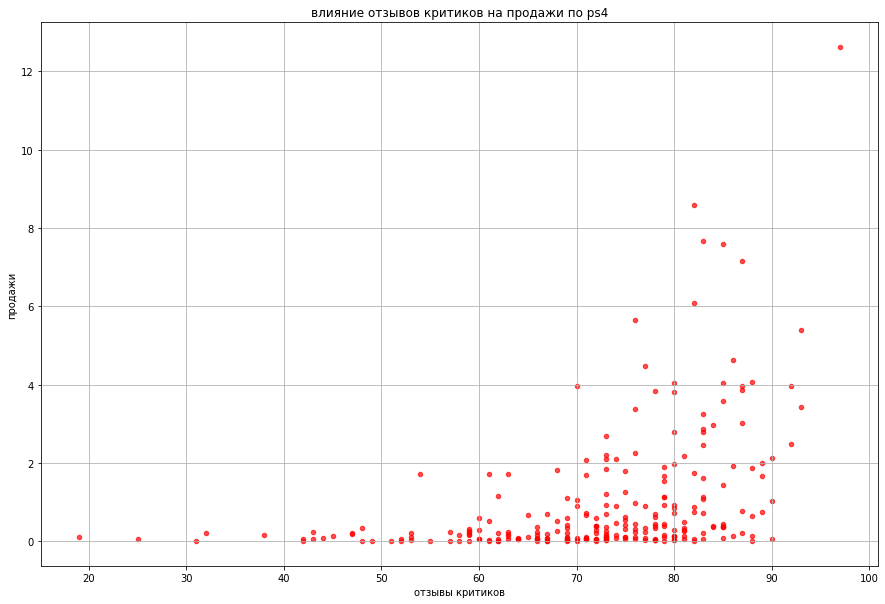

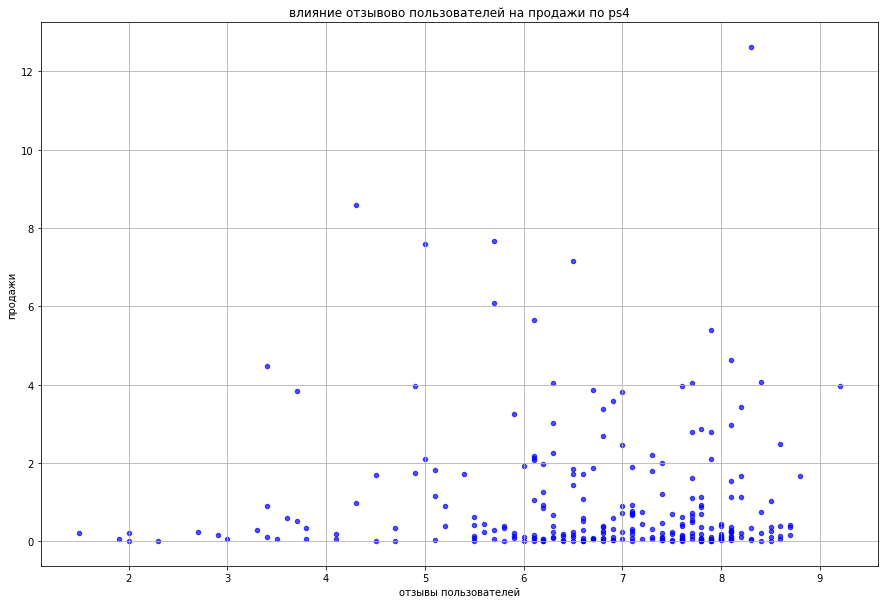

In [15]:
# построим диаграмму рассеивания
plot1 = actual_games2_ps4.plot(
    kind = 'scatter', x='critic_score', y='total_sales', figsize=(15,10), legend=True, grid=True, 
    alpha=0.7, title='влияние отзывов критиков на продажи по ps4', color='red')
plot2 = actual_games2_ps4.plot(
    kind = 'scatter', x='user_score', y='total_sales', figsize=(15,10), legend=True, grid=True, 
    alpha=0.7, title='влияние отзывово пользователей на продажи по ps4', color='blue')
plot1.set_xlabel('отзывы критиков'), plot1.set_ylabel('продажи')
plot2.set_xlabel('отзывы пользователей'), plot2.set_ylabel('продажи')
print()

2. XOne

In [16]:
# создадим таблицу для XOne со столбцами только из отзывов и выручки
actual_games2_xone = actual_games2[(
    actual_games2['platform'] == 'XOne')][['total_sales', 'critic_score', 'user_score']]
display(actual_games2_xone.corr())

,total_sales,critic_score,user_score
total_sales,1.000000,0.416998,-0.068925
critic_score,0.416998,1.000000,0.472462
user_score,-0.068925,0.472462,1.000000


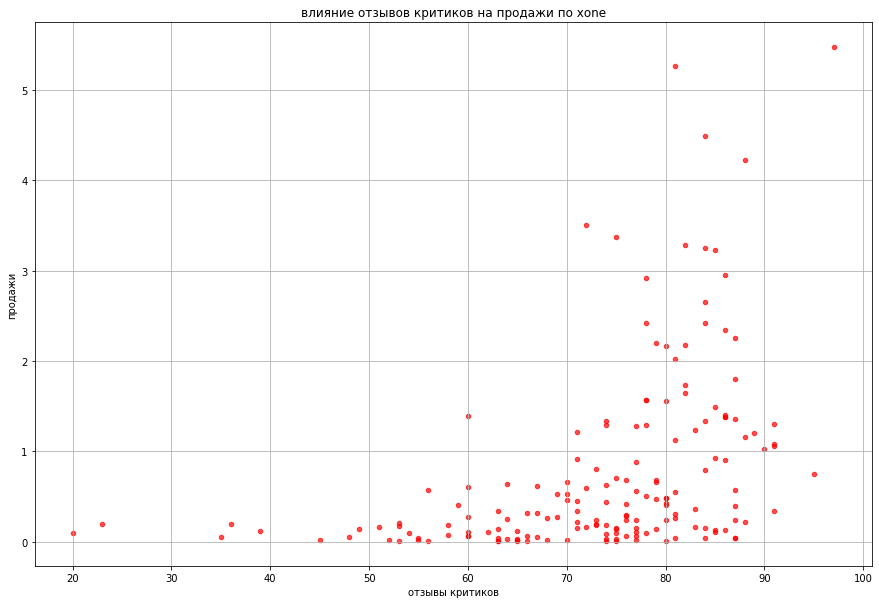

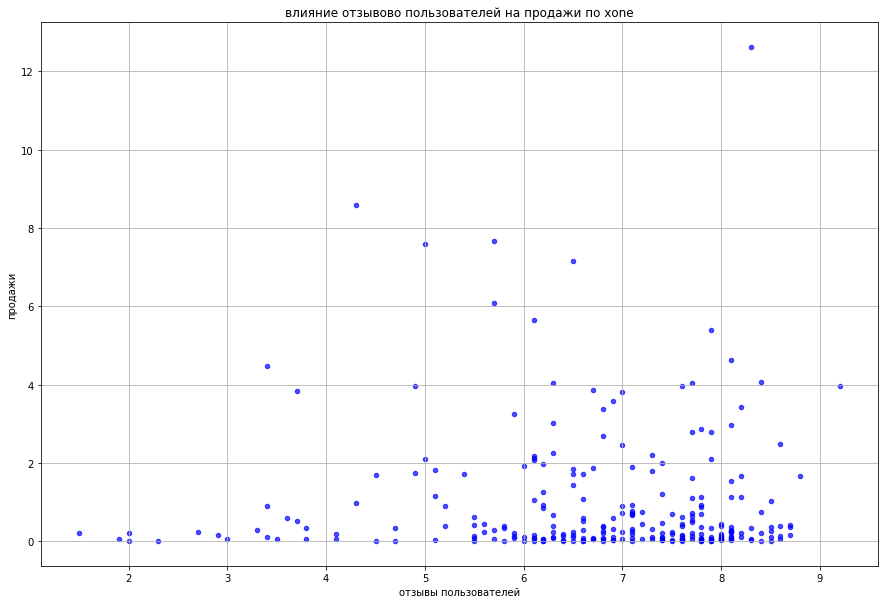

In [17]:
# построим диаграмму рассеивания
plot1 = actual_games2_xone.plot(
    kind = 'scatter', x='critic_score', y='total_sales', figsize=(15,10), legend=True, grid=True, 
    alpha=0.7, title='влияние отзывов критиков на продажи по xone', color='red')
plot2 = actual_games2_ps4.plot(
    kind = 'scatter', x='user_score', y='total_sales', figsize=(15,10), legend=True, grid=True, 
    alpha=0.7, title='влияние отзывово пользователей на продажи по xone', color='blue')
plot1.set_xlabel('отзывы критиков'), plot1.set_ylabel('продажи')
plot2.set_xlabel('отзывы пользователей'), plot2.set_ylabel('продажи')
print()

3. 3DS

In [18]:
# создадим таблицу для 3DS со столбцами только из отзывов и выручки
actual_games2_3ds = actual_games2[(
    actual_games2['platform'] == '3DS')][['total_sales', 'critic_score', 'user_score']]
display(actual_games2_3ds.corr())

,total_sales,critic_score,user_score
total_sales,1.000000,0.320803,0.197583
critic_score,0.320803,1.000000,0.722762
user_score,0.197583,0.722762,1.000000


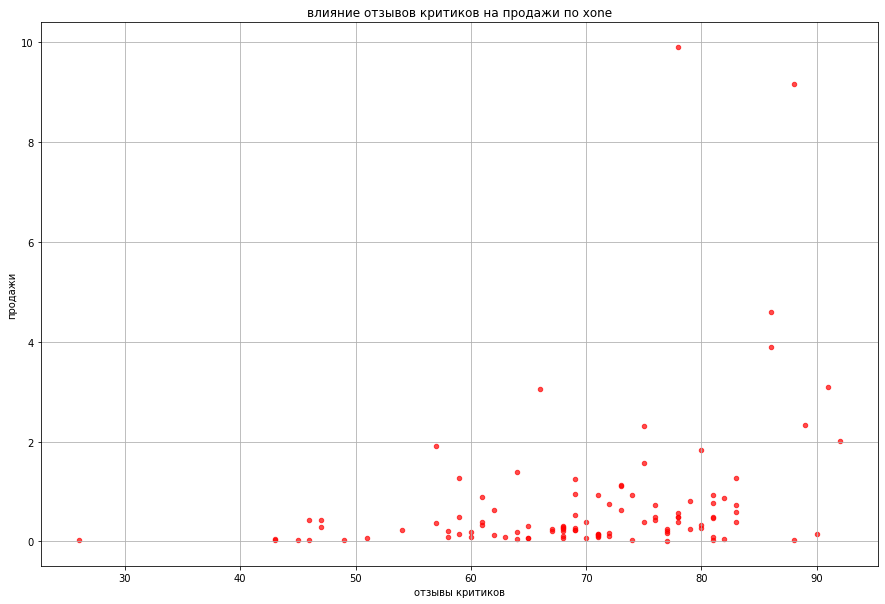

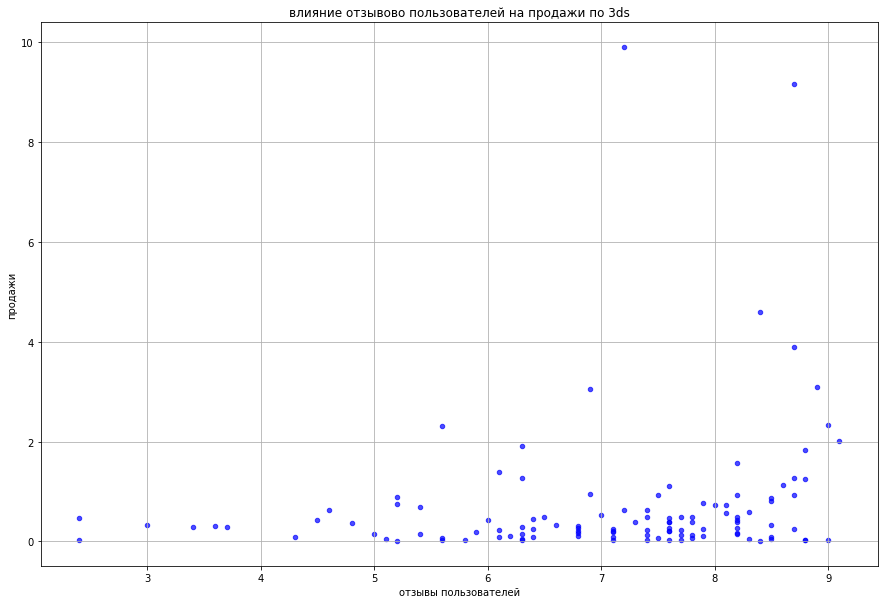

In [19]:
# построим диаграмму рассеивания
plot1 = actual_games2_3ds.plot(
    kind = 'scatter', x='critic_score', y='total_sales', figsize=(15,10), legend=True, grid=True, 
    alpha=0.7, title='влияние отзывов критиков на продажи по xone', color='red')
plot2 = actual_games2_3ds.plot(
    kind = 'scatter', x='user_score', y='total_sales', figsize=(15,10), legend=True, grid=True, 
    alpha=0.7, title='влияние отзывово пользователей на продажи по 3ds', color='blue')
plot1.set_xlabel('отзывы критиков'), plot1.set_ylabel('продажи')
plot2.set_xlabel('отзывы пользователей'), plot2.set_ylabel('продажи')
print()

### Вывод
Исходя из корреляции и диаграммы рассеивания можно смело сказать что:
1. Для PS4 прослеживается связь продаж с отзывами критиков, коэф. 0.4, а с отзывами пользователей связь очень мала.
2. Для XOne ситуация схожая, коэф. 0.41 у критиков, и очень низкий у пользователей.
3. 3DS связь отличается, 0.32 у критиков против 0.2 у пользователей. Интересная связь.
Общий вывод следующий, отзывы критиков реально коррелируют с продажами.

### Посмотрим на общее распределение игр по жанрам.

In [20]:
# создадим сводную таблицу состоящую из жанров и продаж
actual_games2_genre_pivot = actual_games2.pivot_table(
    index = 'genre', values = 'total_sales', aggfunc = ['sum', 'count'])
actual_games2_genre_pivot.columns = ['sales', 'games']
actual_games2_genre_pivot['sales_for_game'] = actual_games2_genre_pivot['sales'] / actual_games2_genre_pivot['games']

display(actual_games2_genre_pivot.sort_values(by = 'sales', ascending = False))

,sales,games,sales_for_game
genre,,,
Action,178.90,385,0.464675
Shooter,149.02,81,1.839753
Role-Playing,118.84,144,0.825278
Sports,86.58,96,0.901875
Platform,27.73,36,0.770278
Misc,25.07,80,0.313375
Racing,22.21,40,0.555250
Simulation,21.85,30,0.728333
Fighting,19.56,34,0.575294


### Вывод
Самыми прибыльными жанрами являются: Action, Shooter, Role-Playing и Sports. Они же лидеры по количеству выпущенных игр в жанре. Соответственно, чем популярнее жанр, тем больше игр в нем и тем больше прибыль от продаж. Хотя когда мы добавили столбец со средней стоимостью одной игры, то среди 4 -х лидеров по общим продажам появился один жанр с очень низкой средней стоимостью, Action, то есть в этом жанре большие продажи, но только за счет того что много игр. Остальные же 3 жанра показали, что наряду с большой прибылью у них и самые большие средние цены.
Аутсайдерами как по прибыли, так и по средней цене стали такие жанры: Adventure, Puzzle и Strategy.


## Составим портрет пользователя каждого региона.

In [21]:
# составим сводную таблицу для платформ
actual_games_region_platform_pivot = (
    actual_games.pivot_table(index = 'platform', values =['na_sales', 'eu_sales', 'jp_sales'],
                                                             aggfunc = 'sum'))
display(actual_games_region_platform_pivot)

,eu_sales,jp_sales,na_sales
platform,,,
3DS,42.64,87.79,55.31
DS,3.53,3.72,4.59
PC,37.76,0.00,19.12
PS3,106.86,35.29,103.38
PS4,141.09,15.96,108.74
PSP,0.42,10.47,0.13
PSV,11.36,21.04,10.98
Wii,11.92,3.39,17.45
WiiU,25.13,13.01,38.10


In [22]:
# составим сводную таблицу для жанров
actual_games_region_genre_pivot = (
    actual_games.pivot_table(index = 'genre', values =['na_sales', 'eu_sales', 'jp_sales'],
                                                             aggfunc = 'sum'))
display(actual_games_region_genre_pivot)

,eu_sales,jp_sales,na_sales
genre,,,
Action,159.34,52.80,177.84
Adventure,9.46,8.24,8.92
Fighting,10.79,9.44,19.79
Misc,26.32,12.86,38.19
Platform,21.41,8.63,25.38
Puzzle,1.40,2.14,1.13
Racing,27.29,2.50,17.22
Role-Playing,48.53,65.44,64.00
Shooter,113.47,9.23,144.77


регион NA

,na_sales,%
platform,,
X360,140.05,27.976428
PS4,108.74,21.721934
PS3,103.38,20.651219
XOne,93.12,18.601678
3DS,55.31,11.048742


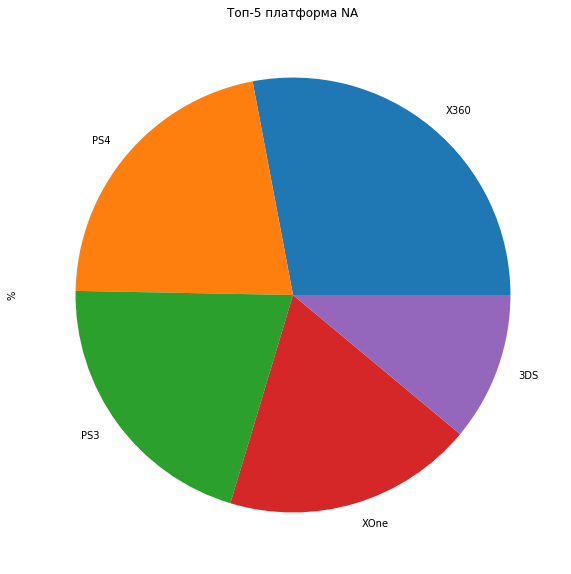

In [23]:
# самые популярные платформы (топ-5)
platforms_na = actual_games_region_platform_pivot['na_sales'].sort_values(ascending = False).head(5)
platforms_na = pd.DataFrame(platforms_na)
platforms_na['%'] = platforms_na['na_sales'] / platforms_na['na_sales'].sum() * 100
display(platforms_na)

# построим график, для наглядности попробуем построить круговую диаграмму
platforms_na.sort_values(by = '%', ascending = False)
platforms_na.plot(
    kind = 'pie', y='%', figsize=(10,10), title = 'Топ-5 платформа NA', legend=False)
plt.show()

,na_sales,%
genre,,
Action,177.84,35.123339
Shooter,144.77,28.592025
Sports,81.53,16.102147
Role-Playing,64.00,12.639978
Misc,38.19,7.542512


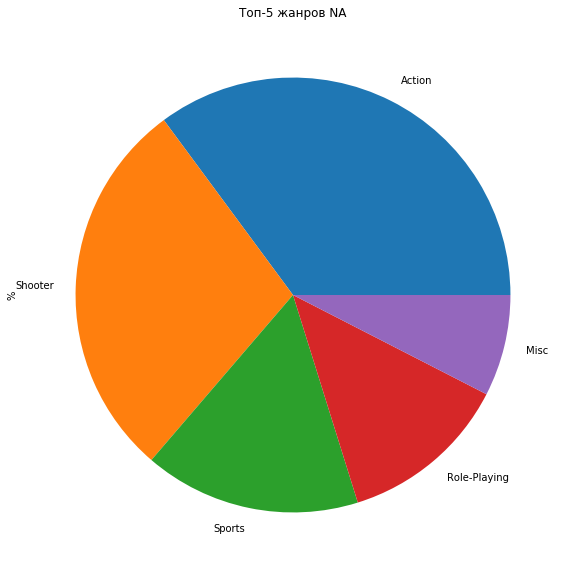

In [24]:
# самые популярные жанры (топ-5)
genres_na = actual_games_region_genre_pivot['na_sales'].sort_values(ascending = False).head(5)
genres_na = pd.DataFrame(genres_na)
genres_na['%'] = genres_na['na_sales'] / genres_na['na_sales'].sum() * 100
display(genres_na)

# построим график
genres_na.sort_values(by = '%', ascending = False)
genres_na.plot(
    kind = 'pie', y='%', figsize=(10,10), title = 'Топ-5 жанров NA', legend=False)
plt.show()

регион EU

,eu_sales,%
platform,,
PS4,141.09,33.858891
PS3,106.86,25.644348
X360,74.52,17.883369
XOne,51.59,12.380610
3DS,42.64,10.232781


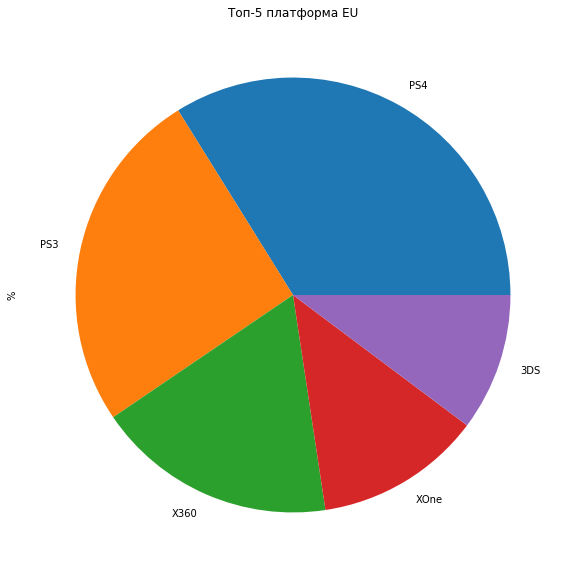

In [25]:
# самые популярные платформы (топ-5)
platforms_eu = actual_games_region_platform_pivot['eu_sales'].sort_values(ascending = False).head(5)
platforms_eu = pd.DataFrame(platforms_eu)
platforms_eu['%'] = platforms_eu['eu_sales'] / platforms_eu['eu_sales'].sum() * 100
display(platforms_eu)

# построим график
platforms_eu.sort_values(by = '%', ascending = False)
platforms_eu.plot(
    kind = 'pie', y='%', figsize=(10,10), title = 'Топ-5 платформа EU', legend=False)
plt.show()

,eu_sales,%
genre,,
Action,159.34,38.145169
Shooter,113.47,27.164129
Sports,69.09,16.539787
Role-Playing,48.53,11.617830
Racing,27.29,6.533084


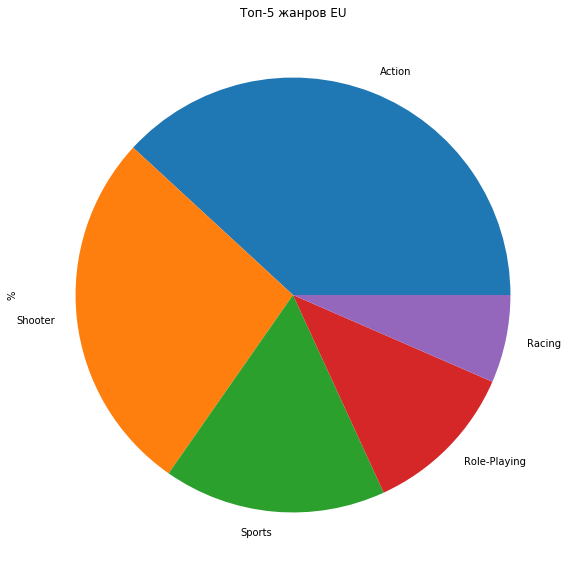

In [26]:
# самые популярные жанры (топ-5)
genres_eu = actual_games_region_genre_pivot['eu_sales'].sort_values(ascending = False).head(5)
genres_eu = pd.DataFrame(genres_eu)
genres_eu['%'] = genres_eu['eu_sales'] / genres_eu['eu_sales'].sum() * 100
display(genres_eu)

# построим график
genres_eu.sort_values(by = '%', ascending = False)
genres_eu.plot(
    kind = 'pie', y='%', figsize=(10,10), title = 'Топ-5 жанров EU', legend=False)
plt.show()

регион JP

,jp_sales,%
platform,,
3DS,87.79,50.719279
PS3,35.29,20.388237
PSV,21.04,12.155526
PS4,15.96,9.220637
WiiU,13.01,7.516321


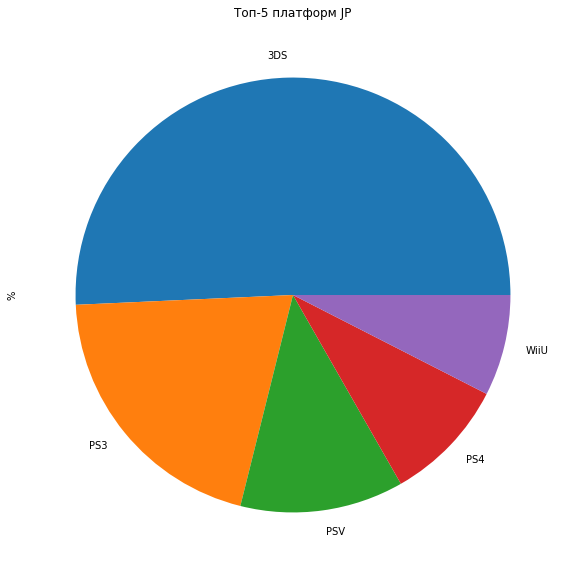

In [27]:
# самые популярные платформы (топ-5)
platforms_jp = actual_games_region_platform_pivot['jp_sales'].sort_values(ascending = False).head(5)
platforms_jp = pd.DataFrame(platforms_jp)
platforms_jp['%'] = platforms_jp['jp_sales'] / platforms_jp['jp_sales'].sum() * 100
display(platforms_jp)

# построим график
platforms_jp.sort_values(by = '%', ascending = False)
platforms_jp.plot(
    kind = 'pie', y='%', figsize=(10,10), title = 'Топ-5 платформ JP', legend=False)
plt.show()

,jp_sales,%
genre,,
Role-Playing,65.44,43.352103
Action,52.80,34.978470
Misc,12.86,8.519377
Simulation,10.41,6.896323
Fighting,9.44,6.253726


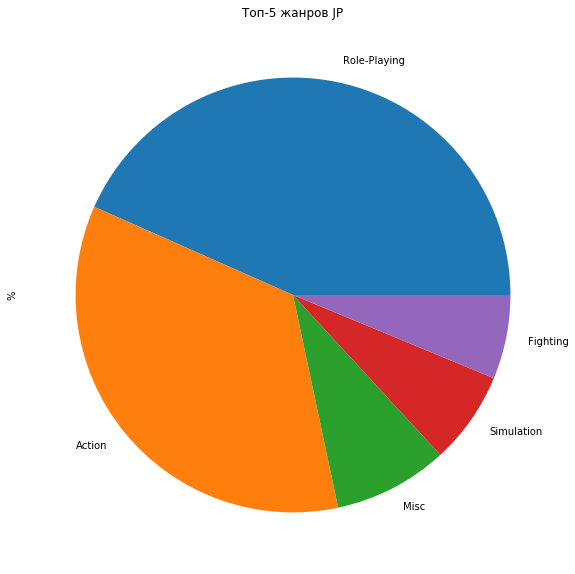

In [28]:
# самые популярные жанры (топ-5)
genres_jp = actual_games_region_genre_pivot['jp_sales'].sort_values(ascending = False).head(5)
genres_jp = pd.DataFrame(genres_jp)
genres_jp['%'] = genres_jp['jp_sales'] / genres_jp['jp_sales'].sum() * 100
display(genres_jp)

# построим график
genres_jp.sort_values(by = '%', ascending = False)
genres_jp.plot(
    kind = 'pie', y='%', figsize=(10,10), title = 'Топ-5 жанров JP', legend=False)
plt.show()

Сравним самые поулярные платформы в регионах.
- В NA:
1. X360 с долей примерно  28%
2. PS4		              22%
3. PS3	                  21%
4. XOne	                  19%
5. 3DS	                  11%
- видим, доли близкие друг к другу. Самая популярная платформа X360, хотя она не входила в топ-3 по всем продажам в мире.


- В EU:
1. PS4	                  34%
2. PS3	                  26%
3. X360	                  18%
4. XOne                   12% 
5. 3DS                    10%
- тут разброс доль чуть больше. Самая популярная платформа PS4, как и в целом в мире.


- В JP:
1. 3DS	                   51%
2. PS3                     20%
3. PSV                     12%
4. PS4	                    9%
5. WiiU                     8%
- разброс по долям ощутимый, более 50% у 3DS, хотя в общих продажахпо всем регионам она третья. Видимо основные продажи по ней в этом регионе.

Теперь сделаем вывод о жанрах.
- В NA:
1. Action	         35%
2. Shooter	         29%
3. Sports	         16%
4. Role-Playing	     13%
5. Misc	              8% 

- В EU:
1. Action	         38%
2. Shooter	         27%
3. Sports	         17%
4. Role-Playing	     12%
5. Racing	          7%
- видим, что в Америке и Европе практически одинаковая картина по долям и лидерам жанров. первые 4 места общие, что в целом почти 92%. 


- В JP:
1. Role-Playing	     43%
2. Action	         35%
3. Misc	              9%
4. Simulation	      7%
5. Fighting	          6%
- в Японии, как обычно, картина совсем другая, опять большой разброс по долям и совсем другой лидер. Role-Playing 43%, на втором месте лидер по Америке и Европе, Action с 35%. Такая разница между Америкой и Европой с одной стороны и Японией с другой связана с разностью культур и национальных особенностей.

### В Америке и Европе пользователи больше предпочитают жанры Action и Shooter, то есть более агрессивные игры, в сумме эти два жанра занимают порядка 65% от общих продаж. В Японии 43% предпочитают Ролевики, более спокойный и созидательный жанр. 

In [29]:
# посмотрим на уникальные значения в столбце rating
print( actual_games['rating'].unique())

# заменим пустые ячйки на NR (no rating)
actual_games['rating'].fillna('NR', inplace=True)
print( actual_games['rating'].unique())

['M' nan 'E' 'E10+' 'T']
['M' 'NR' 'E' 'E10+' 'T']


/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [30]:
# проверим влияние рейтинга ESRB
     # составим сводную таблицу по рейтингу
actual_games_region_rating_pivot = (
    actual_games.pivot_table(
        index = 'rating', values =['na_sales', 'eu_sales', 'jp_sales'], aggfunc = 'sum'))
display(actual_games_region_rating_pivot)

,eu_sales,jp_sales,na_sales
rating,,,
E,113.03,28.33,114.37
E10+,55.37,8.19,75.70
M,193.96,21.20,231.57
NR,91.50,108.84,103.31
T,52.96,26.02,66.02


регион NA

,na_sales,%
rating,,
M,231.57,39.184730
E,114.37,19.352928
NR,103.31,17.481429
E10+,75.70,12.809449
T,66.02,11.171464


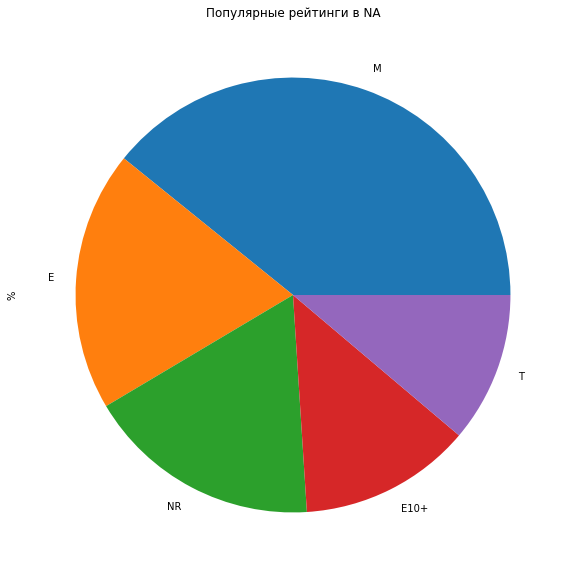

In [31]:
# посмотрим взаимосвясь рейтинга и продаж
rating_na = actual_games_region_rating_pivot['na_sales'].sort_values(ascending = False).head(5)
rating_na = pd.DataFrame(rating_na)
rating_na['%'] = rating_na['na_sales'] / rating_na['na_sales'].sum() * 100
display(rating_na)

# построим график
rating_na.sort_values(by = '%', ascending = False)
rating_na.plot(
    kind = 'pie', y='%', figsize=(10,10), title = 'Популярные рейтинги в NA', legend=False)
plt.show()

регион EU

,eu_sales,%
rating,,
M,193.96,38.269997
E,113.03,22.301803
NR,91.50,18.053747
E10+,55.37,10.924983
T,52.96,10.449469


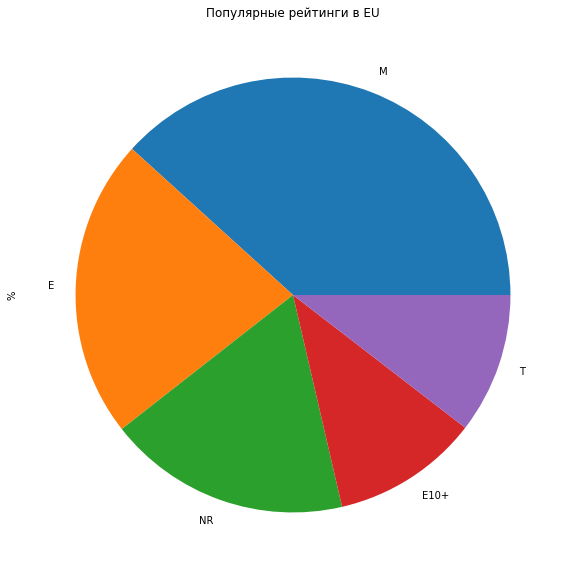

In [32]:
# посмотрим взаимосвясь рейтинга и продаж
rating_eu = actual_games_region_rating_pivot['eu_sales'].sort_values(ascending = False).head(5)
rating_eu = pd.DataFrame(rating_eu)
rating_eu['%'] = rating_eu['eu_sales'] / rating_eu['eu_sales'].sum() * 100
display(rating_eu)

# построим график
rating_eu.sort_values(by = '%', ascending = False)
rating_eu.plot(
    kind = 'pie', y='%', figsize=(10,10), title = 'Популярные рейтинги в EU', legend=False)
plt.show()

регион JP

,jp_sales,%
rating,,
NR,108.84,56.516772
E,28.33,14.710770
T,26.02,13.511268
M,21.20,11.008412
E10+,8.19,4.252778


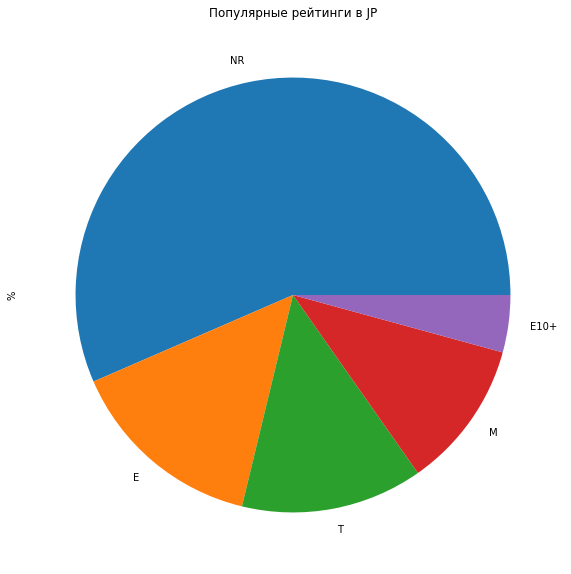

In [33]:
# посмотрим взаимосвясь рейтинга и продаж
rating_jp = actual_games_region_rating_pivot['jp_sales'].sort_values(ascending = False).head(5)
rating_jp = pd.DataFrame(rating_jp)
rating_jp['%'] = rating_jp['jp_sales'] / rating_jp['jp_sales'].sum() * 100
display(rating_jp)

# построим график
rating_jp.sort_values(by = '%', ascending = False)
rating_jp.plot(
    kind = 'pie', y='%', figsize=(10,10), title = 'Популярные рейтинги в JP', legend=False)
plt.show()

### Вывод
Опять видим практически полное сходство в Америке и Европе. Первое место - Для взрослых примерно 38-39%, второе - для всех с 19% в Америке и 22% в Европе, третье - игры без рейтинга с 17% и 18% соответственно.
В Японии на первом месте игры для без рейтинга - 57%!!, потом для всех - 15% и 14% для подростков.
Видим, что в Америке и Европе большей популярностью пользуются игры для взростлых это связано с тем, что популярные жанры тут Экшн и стрелялки, в Японии же больше половины продаж у игр без рейтинга. Может это связано с любовью к ролевым японским играм, возможно они популярны только в Японии и ESRB не присваиваа им рейтинг.

## Построим гипотезы

Гипотеза 1.Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.
Нулевая гипотеза - Средние пользовательские рейтинги платформы Xbox One  равны Средним пользовательским рейтингам платформы PC.
Альтернативная гипотеза - Средние пользовательские рейтинги платформы Xbox One  не равны Средним пользовательским рейтингам платформы PC.

In [34]:
# создадим 2 таблицы, одну для Xbox, вторую для PC
xone_u_s = actual_games.query('platform == "XOne"')
pc_u_s = actual_games.query('platform == "PC"')

# посмотрим на средние пользовательские рейтинги
print(xone_u_s['user_score'].mean())
print()
print(pc_u_s['user_score'].mean())
print()
# проверим гипотезу
alpha = 0.05
results = sp.stats.ttest_ind(
    xone_u_s['user_score'], pc_u_s['user_score'], nan_policy='omit')
print('P-value:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

6.521428571428572

6.428640776699029

P-value: 0.5535080500642724
Не получилось отвергнуть нулевую гипотезу


Выборки независимы, поэтому используем метод ttest_ind. P-value = 0.55.
Не получилось отвергнуть нулевую гипотезу о равенстве средних пользовательских рейтингов двух платформ.

Гипотеза 2.Средние пользовательские рейтинги жанров Action и Sports разные.
Нулевая гипотеза - Средние пользовательские рейтинги жанров Action и Sports равны.
Альтернативная гипотеза - редние пользовательские рейтинги жанров Action и Sports разные.

In [35]:
# создадим 2 таблицы, одну для Action, вторую для Sports
action_u_s = actual_games.query('genre == "Action"')
sports_u_s = actual_games.query('genre == "Sports"')
# посмотрим на средние пользовательские рейтинги
print(action_u_s['user_score'].mean())
print()
print(sports_u_s['user_score'].mean())
print()
# проверим гипотезу
alpha = 0.05
results = sp.stats.ttest_ind(
    action_u_s['user_score'], sports_u_s['user_score'], nan_policy='omit')
print('P-value:', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

6.825047801147227

5.455897435897437

P-value: 3.716308946093586e-26
Отвергаем нулевую гипотезу


Выборки независимы, поэтому используем метод ttest_ind. P-value очень мало. Нулевая гипотеза о равенстве средних пользовательских рейтингов двух жанров отвергнута.

## Вывод
В ходе исследования были проверены две гипотезы. alpha = 0.05, то есть 5 %.
- Гипотеза 1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые. Нулевая гипотеза - Средние пользовательские рейтинги платформы Xbox One равны Средним пользовательским рейтингам платформы PC. Нам не удалось ее отвергнуть.
- Гипотеза 2.Средние пользовательские рейтинги жанров Action и Sports разные. Нулевая гипотеза - Средние пользовательские рейтинги жанров Action и Sports равны. Нулевая гипотеза отвергнута.

## Общий вывод
На успешность игры влияют разные факторы: 
- оценки пользователей;
- оценки критиков;
- жанр;
- платформа
- рейтинг 
- регион.

Учитывая современные реалии и опираясь на данный анализ я бы посоветовал обратить внимание на игры:
- которые выходят на платформах: PS4 и XONE, их популярность растет и они еще не исчерпали себя;
- далее исходя из регионов выбирал бы жанр. Если это NA и EU то лучше выбирать: action и shooter. Если JP то жанры: action и role-playing.
- возрастной рейтинг также зависит от регионов. Если это NA и EU то лучше выбирать: для взрослых, для всех и от 10 лет. Если JP то : игры для всех, для подростков и для взрослых.